In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import ase
import ase.io as aio
import qml

import scipy as sp
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from qml.kernels import gaussian_kernel
from qml.math import cho_solve
import copy
%config Completer.use_jedi = False
%matplotlib notebook

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
data = pd.read_csv('./data.csv', index_col=0)

data.head()

,mol,Eafw,Earev,dErxn,ETS,ERt,EPr,enan,HRt,HPr,HTS,Hafw,dH
0,1abp1,8.674063,17.793659,-9.119595,-1.453883e+06,-1.453892e+06,-1.453901e+06,R,-1.453681e+06,-1.453689e+06,-1.453672e+06,8.495217,-7.957442
1,1abp2,7.572784,19.457186,-11.884402,-1.453885e+06,-1.453892e+06,-1.453904e+06,R,-1.453681e+06,-1.453691e+06,-1.453673e+06,7.375741,-10.650710
2,1abp3,12.316128,22.034368,-9.718239,-1.453878e+06,-1.453891e+06,-1.453900e+06,R,-1.453679e+06,-1.453688e+06,-1.453667e+06,12.109041,-8.383520
3,1abp4,9.298435,22.482409,-13.183974,-1.453880e+06,-1.453889e+06,-1.453902e+06,R,-1.453678e+06,-1.453690e+06,-1.453669e+06,9.181712,-11.817877
4,1abp5,10.178204,22.937354,-12.759150,-1.453881e+06,-1.453892e+06,-1.453904e+06,R,-1.453680e+06,-1.453692e+06,-1.453670e+06,9.975511,-11.326537


In [ ]:
data['ase_reactants'] = [aio.read(
    'data_react_xyz/' + data.mol.values[i] + data.enan.values[i] + '.xyz') for i in range(len(data))]

data['ase_products'] = [aio.read(
    'data_react_xyz/' + data.mol.values[i] + data.enan.values[i] + '.xyz') for i in range(len(data))]

mbtypes = np.load('./mbtypes.npy', allow_pickle=True)

data['SLATM_react'] = [qml.representations.generate_slatm(coordinates=mol.positions, 
                                                 nuclear_charges=mol.get_atomic_numbers(), 
                                                mbtypes=mbtypes, local=False) for mol in data['ase_reactants']]

data['SLATM_prod'] = [qml.representations.generate_slatm(coordinates=mol.positions, 
                                                 nuclear_charges=mol.get_atomic_numbers(), 
                                                mbtypes=mbtypes, local=False) for mol in data['ase_products']]


In [4]:
data['SLATM_diff'] = [x - y for x,y in zip(data.SLATM_prod.values, data.SLATM_react.values)]

The target is the Forward activation energy

In [5]:
Y = data.Eafw

In [6]:
slatm2 = np.vstack(data.SLATM_react.values)

In [7]:
slatmdiff = np.vstack(data.SLATM_diff.values)

# Representation distance vs target distance

First we compare the dissimilarity plots of SLATM2 vs SLATMDIFF

In [8]:
dmat_slatm2 = sk.metrics.pairwise.pairwise_distances(slatm2)


dmat_slatmdiff = sk.metrics.pairwise.pairwise_distances(slatmdiff)


dmat_target = np.subtract.outer(data.Eafw.values, data.Eafw.values)

<IPython.core.display.Javascript object>


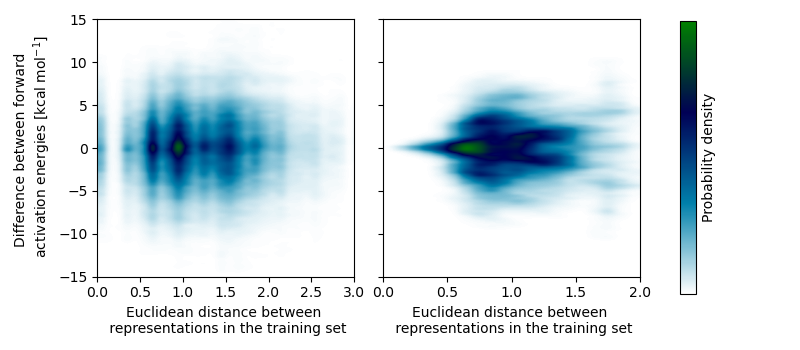

In [9]:
fig, axes = plt.subplots(ncols=2, figsize=[8,3.5], sharey=True)

ax = axes[0]
hist, xedges, yedges = np.histogram2d(1 / dmat_slatm2.mean() * dmat_slatm2[np.triu_indices_from(dmat_slatm2, k=1)], 
                                      dmat_target[np.triu_indices_from(dmat_target, k=1)], 
                                      bins=100, range=[[0,8], [-15,15]])
ax.imshow(hist.T, aspect='auto', origin='lower left', 
          interpolation='gaussian', 
          extent=[0,10,-20,20],
          cmap='ocean_r')


ax = axes[1]
hist, xedges, yedges = np.histogram2d(1 / dmat_slatmdiff.mean() * dmat_slatmdiff[np.triu_indices_from(dmat_slatmdiff, k=1)], 
                                      dmat_target[np.triu_indices_from(dmat_target, k=1)], 
                                      bins=100, range=[[0,8], [-15,15]], density=True)

cax = ax.imshow(hist.T, aspect='auto', origin='lower left', 
          interpolation='gaussian', extent=[0,10,-15,15],
         cmap='ocean_r')


# axes[0].set_xlim(0,4)
axes[0].set_xlim(0,3)
axes[1].set_xlim(0,2)

axes[1].set_xlabel('Euclidean distance between \n representations in the training set')
axes[0].set_xlabel('Euclidean distance between \n representations in the training set')

axes[0].set_ylabel('Difference between forward \n activation energies [kcal mol$^{-1}$]')
axes[0].set_ylim(-15,15)
plt.tight_layout(pad=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.78])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_ticks([])
cbar.set_label('Probability density')

# fig.savefig('sim_plot_LR.png', dpi=300)
# fig.savefig('sim_plots.png', dpi=300)
# fig.savefig('sim_plots.pdf')

plt.show()

# Feature importance analysis

Then we compare the variance of each feature with the importance score

In [10]:
variances = np.var(slatmdiff, axis=0)

In [17]:
# Here we use the regression coefficients between each feature and the target as importance score
lin_regs = [sp.stats.linregress(xs, ys) for xs, ys in zip(slatmdiff.T, [Y for i in range(slatmdiff.shape[1])])]
rvalues = np.array([ccc.rvalue for ccc in lin_regs])

<IPython.core.display.Javascript object>


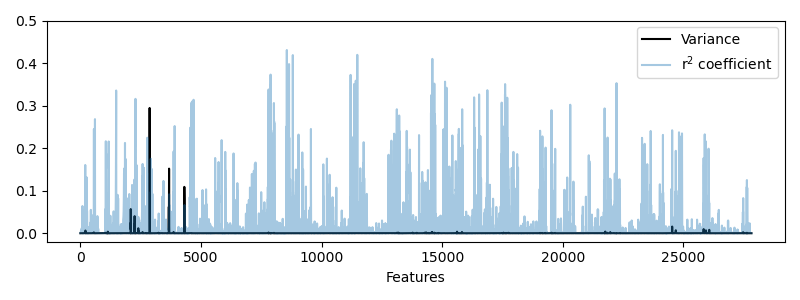

In [12]:
fig, ax = plt.subplots(figsize=[8,3])

ax.plot(variances, label='Variance', c='black')
ax.plot(rvalues ** 2, alpha=0.4, label='r$^2$ coefficient', c='C0')

ax.legend(ncol=1, fontsize=10)
ax.set_ylim(-0.02, 0.5)
ax.set_xlabel('Features')
plt.tight_layout()
fig.savefig('./feature_regression.png', dpi=300)
plt.show()

In [13]:
# We take the 500 features with the highest r2 value and normalize them with a min max scaler
# Here this is done for the whole data to ilustrate the dissimilarity plots, for the training this step will be 
# done for each train split.

num = 500
slatmdiffp = sk.preprocessing.MinMaxScaler().fit_transform(slatmdiff[:, np.argsort(rvalues ** 2)[-num:]])


In [14]:
dmat_slatmdiffp = sk.metrics.pairwise.pairwise_distances(slatmdiffp, n_jobs=-1)

<IPython.core.display.Javascript object>


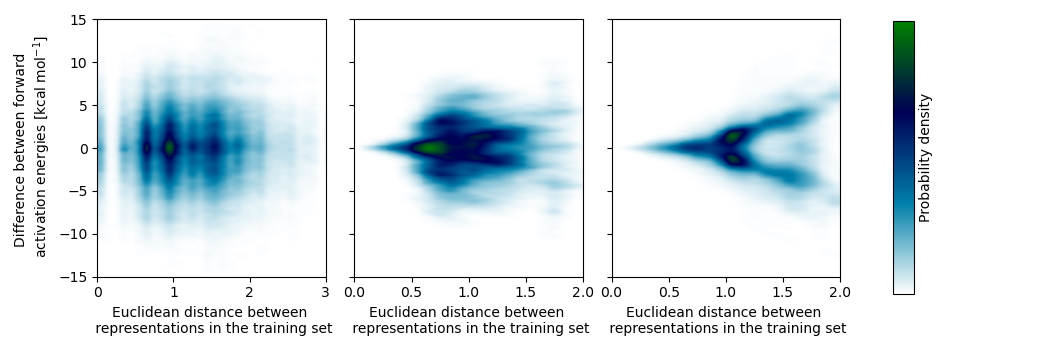

In [15]:
fig, axes = plt.subplots(ncols=3, figsize=[10.5,3.5], sharey=True)

ax = axes[0]
hist, xedges, yedges = np.histogram2d(1 / dmat_slatm2.mean() * dmat_slatm2[np.triu_indices_from(dmat_slatm2, k=1)], 
                                      dmat_target[np.triu_indices_from(dmat_target, k=1)], 
                                      bins=100, range=[[0,8], [-15,15]])
ax.imshow(hist.T, aspect='auto', origin='lower left', 
          interpolation='gaussian', 
          extent=[0,10,-20,20],
          cmap='ocean_r')


ax = axes[1]
hist, xedges, yedges = np.histogram2d(1 / dmat_slatmdiff.mean() * dmat_slatmdiff[np.triu_indices_from(dmat_slatmdiff, k=1)], 
                                      dmat_target[np.triu_indices_from(dmat_target, k=1)], 
                                      bins=100, range=[[0,8], [-15,15]], density=True)

cax = ax.imshow(hist.T, aspect='auto', origin='lower left', 
          interpolation='gaussian', extent=[0,10,-15,15],
         cmap='ocean_r')

ax = axes[2]
hist, xedges, yedges = np.histogram2d(
    1 / dmat_slatmdiffp.mean() * dmat_slatmdiffp[np.triu_indices_from(dmat_slatmdiffp, k=1)], 
    dmat_target[np.triu_indices_from(dmat_target, k=1)], 
    bins=100, range=[[0,8], [-15,15]], density=True)

cax = ax.imshow(hist.T, aspect='auto', origin='lower left', 
          interpolation='gaussian', extent=[0,10,-15,15],
         cmap='ocean_r')


axes[0].set_xlim(0,3)
axes[1].set_xlim(0,2)
axes[2].set_xlim(0,2)

axes[0].set_xlabel('Euclidean distance between \n representations in the training set')
axes[1].set_xlabel('Euclidean distance between \n representations in the training set')
axes[2].set_xlabel('Euclidean distance between \n representations in the training set')

axes[0].set_ylabel('Difference between forward \n activation energies [kcal mol$^{-1}$]')
axes[0].set_ylim(-15,15)
plt.tight_layout(pad=1)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.16, 0.02, 0.78])
cbar = fig.colorbar(cax, cax=cbar_ax)
cbar.set_ticks([])
cbar.set_label('Probability density')

# fig.savefig('sim_plot_LR.png', dpi=300)
# fig.savefig('sim_plots.png', dpi=300)
# fig.savefig('sim_plots.pdf')

plt.show()